# Description of the notebook

Students:
- Teka Kimbi Ntimanputu (10673197)
- William Stucchi (10661711)
- Lorenzo Veronese (10654901)

This notebook has been our first step into the transfer learning technique. The following, are the novelties introduced here with respect to the hand-crafted models:
- upsampling of the minority class.
- upsampling of the training set, adding noisy images, cut images and blurred images.
- transfer learning.
- no fine-tuning was applied in this notebook.

# Import libraries

In [ ]:
#Connect to drive
from google.colab import drive

from numpy import load
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import math

# Load dataset

Mount Google Drive:

In [ ]:
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab Notebooks/ANNDL/Challenge1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks/ANNDL/Challenge1


In [ ]:
# Load data
data = load('public_data.npz', allow_pickle=True)
lst = data.files

# Divide the dataset in image set and label set
img_set = data['data']
label_set = data['labels']

# Data cleaning

## Remove evident outliers

### Shrek

In [ ]:
# Select the reference image 'shrek'
shrek = img_set[58]

# list of images to remove
indexes_to_remove = []
for i in range(0, len(img_set)):
    if np.array_equal(shrek, img_set[i]):
        indexes_to_remove.append(i)

print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [58, 95, 137, 138, 171, 207, 506, 571, 599, 622, 658, 692, 779, 827, 840, 880, 901, 974, 1028, 1265, 1268, 1280, 1333, 1443, 1466, 1483, 1528, 1554, 1594, 1651, 1806, 1866, 1938, 1977, 2022, 2081, 2090, 2261, 2311, 2328, 2380, 2435, 2451, 2453, 2515, 2663, 2665, 2675, 2727, 2734, 2736, 2755, 2779, 2800, 2830, 2864, 2866, 2913, 2937, 3033, 3055, 3105, 3144, 3155, 3286, 3410, 3488, 3572, 3583, 3666, 3688, 3770, 3801, 3802, 3806, 3811, 3862, 3885, 3927, 3931, 3946, 3988, 4097, 4118, 4144, 4150, 4282, 4368, 4475, 4476, 4507, 4694, 4740, 4779, 4857, 5082, 5121, 5171]
Number of indexes to remove: 98


In [ ]:
print("Length before removing Shrek: ", len(img_set))

img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]

print("Length after removing Shrek: ", len(img_set))

Length before removing Shrek:  5200
Length after removing Shrek:  5102


### Trololo

In [ ]:
# Select the reference image 'trololo'
trololo = img_set[332]  # Note: It is 332 AFTER removing 'Shrek'


indexes_to_remove = []
for i in range(0, len(img_set)):
    if np.array_equal(trololo, img_set[i]):
         indexes_to_remove.append(i)

print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [332, 406, 428, 480, 522, 689, 711, 713, 741, 770, 882, 944, 954, 971, 1025, 1045, 1046, 1082, 1130, 1153, 1171, 1172, 1361, 1514, 1580, 1601, 1660, 1667, 1722, 1727, 1729, 1797, 1871, 1906, 1947, 1954, 2113, 2154, 2155, 2161, 2308, 2385, 2443, 2452, 2519, 2536, 2548, 2551, 2628, 2743, 2776, 2784, 2832, 2871, 2989, 3025, 3046, 3311, 3370, 3385, 3423, 3629, 3669, 3728, 3745, 3759, 3818, 3821, 3826, 3869, 3883, 3907, 3967, 3973, 4017, 4223, 4227, 4229, 4323, 4413, 4466, 4514, 4527, 4627, 4643, 4673, 4743, 4754, 4765, 4788, 4802, 4808, 4812, 4832, 4953, 4985, 5046, 5068]
Number of indexes to remove: 98


In [ ]:
print("Length before removing Trololo: ", len(img_set))

img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]

print("Length after removing Trololo: ", len(img_set))

Length before removing Trololo:  5102
Length after removing Trololo:  5004


# Prepare for training

### To categorical

Convert to categorical:
- healthy -> [1 0]
- unhealthy -> [0 1]

In [ ]:
# Define a mapping from label strings to numerical values
labels_string_to_num = {'healthy': 0, 'unhealthy': 1}

# Replace label strings with numerical values
for i in range(0, len(label_set)):
    label_set[i] = labels_string_to_num[label_set[i]]

# Expand the label_set dimensions
label_num = np.expand_dims(label_set, axis=-1)

print("Shape of numeric labels: ", label_num.shape)

# Convert to one-hot encoding
label_cat = tfk.utils.to_categorical(label_num, num_classes=2)

print("Example of categorical label (healthy) after conversion: ", label_cat[0])

Shape of numeric labels:  (5004, 1)
Example of categorical label (healthy) after conversion:  [1. 0.]


### Split train-val

Split between training and validation set with 80-20% as ratio:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(img_set, label_cat, random_state=seed, test_size=0.2, stratify=np.argmax(label_cat, axis=1))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4003, 96, 96, 3), y_train shape: (4003, 2)
X_val shape: (1001, 96, 96, 3), y_val shape: (1001, 2)


# Upsampling

## Unbalanced class

Split the training set between healthy and unhealthy examples:

In [ ]:
#Select the class label of the 'unhealthy' class from the training data
unhealthy_class = y_train[3]

majority_class_indexes = []
for item in range(len(y_train)):
    # Check if the current label is not the same as the 'unhealthy' class
    if (y_train[item][0] == 1.0 and y_train[item][1]==0.0):
        majority_class_indexes.append(item)

# Create a subset of unhealthy and healthy features based on the majority class indexes
unhealthy_features = X_train[~np.isin(np.arange(len(X_train)), majority_class_indexes)]
healthy_features = X_train[np.isin(np.arange(len(X_train)), majority_class_indexes)]

# Create a subset of unhealthy and healthy labels based on the majority class indexes
unhealthy_labels = y_train[~np.isin(np.arange(len(y_train)), majority_class_indexes)]
healthy_labels = y_train[np.isin(np.arange(len(y_train)), majority_class_indexes)]

print('Num Unhealthy: ',len(unhealthy_labels))
print('Num Healthy: ',len(healthy_labels))

Num Unhealthy:  1522
Num Healthy:  2481


Sample without replacement examples from the minority class (in this notebook, class weights have not been applied):

In [ ]:
# The split train-val could result in more healthy samples in the training set
if(len(unhealthy_labels) < len(healthy_labels)):
    # Sample from ids
    ids = np.arange(len(unhealthy_features))
    choices = np.random.choice(ids, len(healthy_features))

    # Create a set of resampled unhealthy samples based on the chosen ids
    res_unhealthy_features = unhealthy_features[choices]
    res_unhealthy_labels = unhealthy_labels[choices]

    print("Shape of resampled unhealthy features:", res_unhealthy_features.shape)

else:
    # Sample from ids
    ids = np.arange(len(healthy_features))
    choices = np.random.choice(ids, len(unhealthy_features))

    # Create a set of resampled unhealthy samples based on the chosen ids
    res_healthy_features = healthy_features[choices]
    res_healthy_labels = healthy_labels[choices]

    print("Shape of resampled healthy features:", res_healthy_features.shape)

Shape of resampled unhealthy features: (2481, 96, 96, 3)


Concatenate to obtain the new training set:

In [ ]:
if(len(unhealthy_labels) < len(healthy_labels)):
    X_train = np.concatenate([res_unhealthy_features, healthy_features], axis=0)
    y_train = np.concatenate([res_unhealthy_labels, healthy_labels], axis=0)
else:
    X_train = np.concatenate([res_healthy_features, unhealthy_features], axis=0)
    y_train = np.concatenate([res_healthy_labels, unhealthy_labels], axis=0)

# Create indexes to reorder images and labels coherently
order = np.arange(len(X_train))
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]
X_train.shape

(4962, 96, 96, 3)

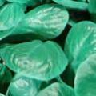

In [ ]:
cv2_imshow(X_train[0])

## Noise

Define the number of noisy images to add. The value "0.05" is a parameter that manages the proportion of syntetic images to add.

In [ ]:
num_samples = math.ceil(len(X_train)*0.05)
print(num_samples)

249


Generate noisy images:

In [ ]:
sampled_noisy_images = []
sampled_noisy_labels = []

X_train_restored = X_train
for i in range(num_samples):
    # Randomly select an image from the training set
    random_index = np.random.randint(len(X_train))
    image = X_train_restored[random_index].copy()

    # Add noise to the image (e.g., Gaussian noise)
    noise = np.random.normal(0, 2, image.shape).astype(np.uint8)
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)

    # Append
    sampled_noisy_images.append(noisy_image)
    sampled_noisy_labels.append(y_train[random_index])

# Convert to np array
sampled_noisy_images = (np.array(sampled_noisy_images)).astype('float32')

In [ ]:
X_train = np.concatenate([sampled_noisy_images, X_train], axis=0)
y_train = np.concatenate([sampled_noisy_labels, y_train], axis=0)
print(len(X_train))

5211


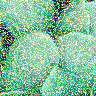

In [ ]:
cv2_imshow(X_train[0])

## Cutting

The initial parameters regulate the type of cuts to add to the image:

In [ ]:
# Define parameters for random erasing
probability = 0.5  # Probability of applying random erasing
min_area = 0.008  # Minimum area of the erased region as a fraction of the total image area
max_area = 0.08  # Maximum area of the erased region as a fraction of the total image area
min_aspect_ratio = 0.3  # Minimum aspect ratio of the erased region
max_aspect_ratio = 2.0  # Maximum aspect ratio of the erased region


sampled_cut_images = []
sampled_cut_labels = []

# Calculate the total area of the image
total_area = image.shape[0] * image.shape[1]

X_train_restored = X_train
for i in range(num_samples):
    # Randomly select an image from the training set
    random_index1 = np.random.randint(len(X_train))
    cut_image = X_train_restored[random_index].copy()
    num_dots = np.random.randint(1,4)


    if np.random.rand() < probability:
    # Randomly select the area and aspect ratio for erasing
        for i in range(num_dots):
            erasing_area = np.random.uniform(min_area, max_area) * total_area
            aspect_ratio = np.random.uniform(min_aspect_ratio, max_aspect_ratio)

            # Calculate the dimensions of the erasing region
            erasing_width = int(np.sqrt(erasing_area * aspect_ratio))
            erasing_height = int(np.sqrt(erasing_area / aspect_ratio))

            # Randomly select the position of the erasing region
            x = np.random.randint(0, cut_image.shape[1] - erasing_width)
            y = np.random.randint(0, cut_image.shape[0] - erasing_height)

            # Apply random erasing by setting the selected region to black
            cut_image[y:y+erasing_height, x:x+erasing_width, :] = 0

        # Append the noisy image to the list
        sampled_cut_images.append(cut_image)
        sampled_cut_labels.append(y_train[random_index1])

sampled_cut_images = (np.array(sampled_cut_images)).astype('float32')

In [ ]:
X_train = np.concatenate([sampled_cut_images, X_train], axis=0)
y_train = np.concatenate([sampled_cut_labels, y_train], axis=0)
print(len(X_train))

5335


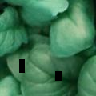

In [ ]:
cv2_imshow(X_train[0])

## Blurring

Add various types of blurring in a random way:

In [ ]:
import cv2

sampled_blurred_images = []
sampled_blurred_labels = []
X_train_restored = X_train
for i in range(num_samples):
    # Randomly select an image from the training set
    random_index = np.random.randint(len(X_train))
    image = X_train_restored[random_index].copy()

    # Do a blurring at random
    blur_type = np.random.randint(6)
    if blur_type == 0:
        blurred_image = cv2.GaussianBlur(image, (3,3), 0).astype(np.uint8)
    elif blur_type == 1:
        blurred_image = cv2.GaussianBlur(image, (5,5), 0).astype(np.uint8)
    elif blur_type == 2:
        blurred_image = cv2.medianBlur(image, 5).astype(np.uint8)
    elif blur_type == 3:
        blurred_image = cv2.bilateralFilter(image, 9, 75, 75).astype(np.uint8)
    elif blur_type == 4:
        kernel = np.ones((3,3),np.float32)/25
        blurred_image = cv2.filter2D(image,-1,kernel).astype(np.uint8)
    elif blur_type == 5:
        kernel = np.ones((5,5),np.float32)/25
        blurred_image = cv2.filter2D(image,-1,kernel).astype(np.uint8)

    # Append
    sampled_blurred_images.append(blurred_image)
    sampled_blurred_labels.append(y_train[random_index])

In [ ]:
X_train = np.concatenate([sampled_blurred_images, X_train], axis=0)
y_train = np.concatenate([sampled_blurred_labels, y_train], axis=0)
print(len(X_train))

5584


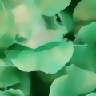

In [ ]:
cv2_imshow(X_train[0])

## Shuffle

After the previous steps, the training set needs to be shuffled in order not to bias the training:

In [ ]:
order = np.arange(len(X_train))
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]
X_train.shape

(5584, 96, 96, 3)

# Transfer learning

## Model

Define parameters for training:

In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model
batch_size = 256                # Batch size for training
epochs = 100                    # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 100
Batch Size: 256
Input Shape: (96, 96, 3)
Output Shape: 2


Import the model from Keras Applications (https://keras.io/api/applications/):

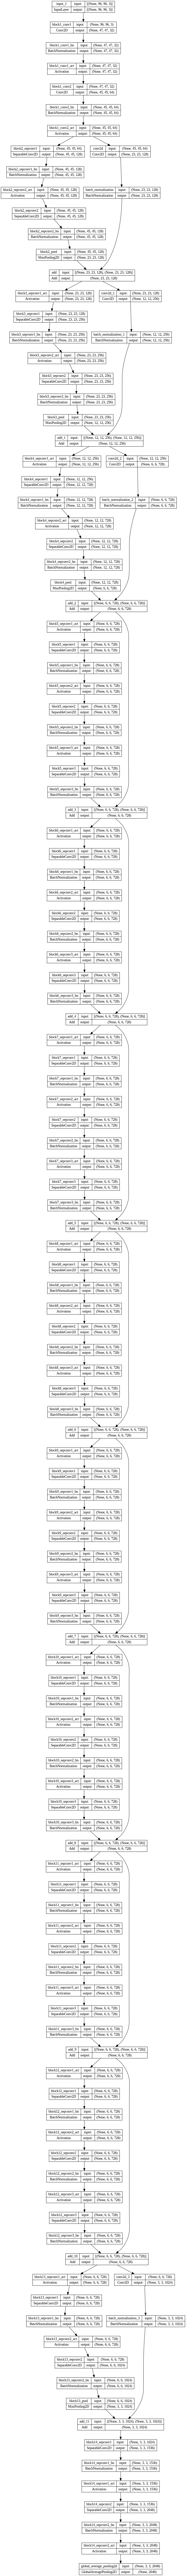

In [ ]:
model = tfk.applications.Xception(
    input_shape = input_shape,
    include_top = False,
    weights = "imagenet",
    pooling = 'avg',
)
tfk.utils.plot_model(model, show_shapes=True)

Define the layers

In [ ]:
# Use the supernet as feature extractor => freeze all its weigths
model.trainable = True

input_layer = tfk.Input(shape = input_shape)

# Data augmentation
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomFlip("vertical"),
        tfkl.RandomZoom(0.2),
        tfkl.RandomTranslation(0.3,0.3),
        tfkl.RandomRotation(0.2),
    ], name='preprocessing')
preprocessing = preprocessing(input_layer)

x = model(input_layer)

# Fully connected part
x = tfkl.Dropout(0.5)(x)
x = tfkl.Dense(units=64, activation='relu')(x)

# Output
output_layer = tfkl.Dense(output_shape, activation='softmax')(x)

# Connect input and output
tl_model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001, weight_decay=5e-2), metrics=['accuracy'])

tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 20992746 (80.08 MB)
Trainable params: 20938218 (79.87 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


Train the model with early stopping.

The ReduceLROnPlateau callback didn't produce interesting results instead.

## Train

In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='auto'),
    #tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)
]

# Train the model
history = tl_model.fit(
    x = tf.keras.applications.xception.preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (tf.keras.applications.xception.preprocess_input(X_val), y_val),
    callbacks = callbacks,
    #class_weight=class_weight # in this notebook, class weights are not implemented: at this step we were doing upsampling of minority class only
).history

# Result:
#   (0.30 upsampling, learning_rate=0.0001, weight_decay=5e-2, dropout 0.5)
#   0.5 val_loss
#   0.81 val_acc
#   0.74 on dataset of phase 1

Epoch 1/100
22/22 [==============================] - 77s 1s/step - loss: 0.6420 - accuracy: 0.6083 - val_loss: 0.7569 - val_accuracy: 0.5355
Epoch 2/100
22/22 [==============================] - 17s 755ms/step - loss: 0.4095 - accuracy: 0.8347 - val_loss: 0.6231 - val_accuracy: 0.7113
Epoch 3/100
22/22 [==============================] - 17s 778ms/step - loss: 0.2104 - accuracy: 0.9174 - val_loss: 0.5775 - val_accuracy: 0.7572
Epoch 4/100
22/22 [==============================] - 17s 790ms/step - loss: 0.1071 - accuracy: 0.9561 - val_loss: 0.5109 - val_accuracy: 0.7832
Epoch 5/100
22/22 [==============================] - 17s 770ms/step - loss: 0.0599 - accuracy: 0.9733 - val_loss: 0.4948 - val_accuracy: 0.8152
Epoch 6/100
22/22 [==============================] - 17s 771ms/step - loss: 0.0469 - accuracy: 0.9735 - val_loss: 0.5106 - val_accuracy: 0.8262
Epoch 7/100
22/22 [==============================] - 16s 750ms/step - loss: 0.0384 - accuracy: 0.9807 - val_loss: 0.5857 - val_accuracy: 0.

Is evident from the graphs the presence of overfitting (while the training loss decreases, the validation loss stays constant):

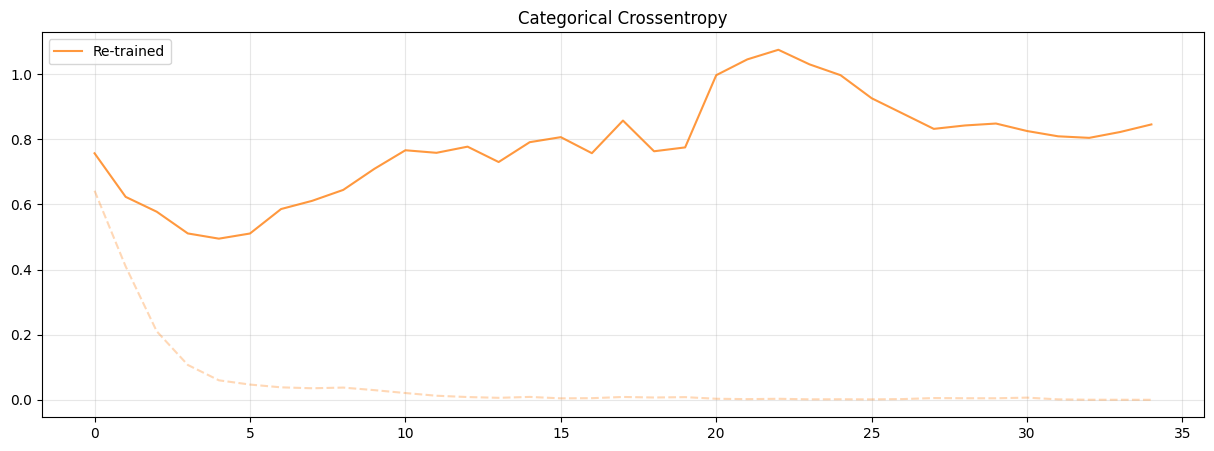

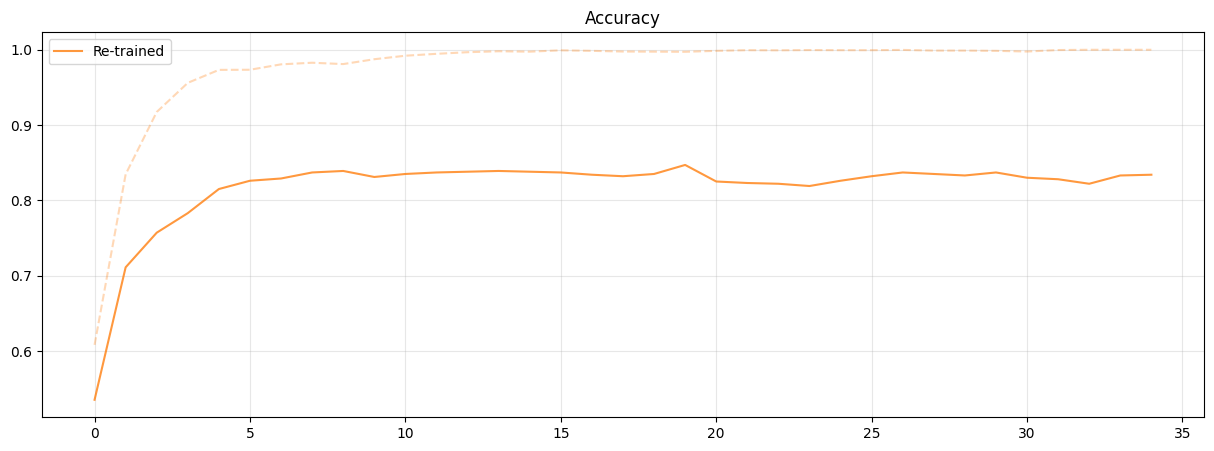

In [ ]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Save

Save the model (with day, hour, and minutes to avoid overlappings):

In [ ]:
from datetime import datetime

current_time = datetime.now() #to avoid overloading
current_day = current_time.day
current_hour = current_time.hour
current_minutes = current_time.minute
tl_model.save("transfer_learning_Xception_0.40ValLoss" + str(current_day) + "_" + str(current_hour) + "_" + str(current_minutes))